### Installation

In [3]:
%%capture
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip install --force-reinstall --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

In [3]:
# Install Hugging Face Transformers library
!pip install transformers datasets torch

### Unsloth

In [4]:
from unsloth import FastVisionModel # FastLanguageModel for LLMs
import torch

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Llama-3.2-11B-Vision-Instruct-bnb-4bit", # Llama 3.2 vision support
    "unsloth/Llama-3.2-11B-Vision-bnb-4bit",
    "unsloth/Llama-3.2-90B-Vision-Instruct-bnb-4bit", # Can fit in a 80GB card!
    "unsloth/Llama-3.2-90B-Vision-bnb-4bit",

    "unsloth/Pixtral-12B-2409-bnb-4bit",              # Pixtral fits in 16GB!
    "unsloth/Pixtral-12B-Base-2409-bnb-4bit",         # Pixtral base model

    "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit",          # Qwen2 VL support
    "unsloth/Qwen2-VL-7B-Instruct-bnb-4bit",
    "unsloth/Qwen2-VL-72B-Instruct-bnb-4bit",

    "unsloth/llava-v1.6-mistral-7b-hf-bnb-4bit",      # Any Llava variant works!
    "unsloth/llava-1.5-7b-hf-bnb-4bit",
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastVisionModel.from_pretrained(
    "unsloth/Llama-3.2-11B-Vision-Instruct",
    load_in_4bit = True, # Use 4bit to reduce memory use. False for 16bit LoRA.
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for long context
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.1.7: Fast Mllama vision patching. Transformers: 4.47.1.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post1. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors.index.json:   0%|          | 0.00/375k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.94G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/55.9k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/5.15k [00:00<?, ?B/s]

\We now add LoRA adapters for parameter efficient finetuning - this allows us to only efficiently train 1% of all parameters.

**[NEW]** We also support finetuning ONLY the vision part of the model, or ONLY the language part. Or you can select both! You can also select to finetune the attention or the MLP layers!

In [5]:
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = False, # False if not finetuning vision layers
    finetune_language_layers   = True, # False if not finetuning language layers
    finetune_attention_modules = True, # False if not finetuning attention layers
    finetune_mlp_modules       = True, # False if not finetuning MLP layers

    r = 16,           # The larger, the higher the accuracy, but might overfit
    lora_alpha = 16,  # Recommended alpha == r at least
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,  # We support rank stabilized LoRA
    loftq_config = None, # And LoftQ
    # target_modules = "all-linear", # Optional now! Can specify a list if needed
)

Unsloth: Making `model.base_model.model.language_model` require gradients


<a name="Data"></a>
### Data Prep
We'll be using a sampled version of the ROCO radiography dataset. You can access the dataset [here](https://huggingface.co/datasets/unsloth/Radiology_mini). The full dataset is [here](https://huggingface.co/datasets/eltorio/ROCOv2-radiology).

The dataset includes X-rays, CT scans and ultrasounds showcasing medical conditions and diseases. Each image has a caption written by experts describing it. The goal is to finetune a VLM to make it a useful analysis tool for medical professionals.


In [6]:
from datasets import load_dataset

#dataset = load_dataset("eltorio/ROCOv2-radiology", split="train") #the full dataset
dataset = load_dataset("unsloth/Radiology_mini", split="train") #the mini dataset


README.md:   0%|          | 0.00/610 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/481M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/79.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1978 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/327 [00:00<?, ? examples/s]

In [7]:
from datasets import load_dataset

datasetFull = load_dataset("eltorio/ROCOv2-radiology", split="train") #the full dataset
#dataset = load_dataset("unsloth/Radiology_mini", split="train") #the mini dataset

README.md:   0%|          | 0.00/4.50k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/27 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/27 [00:00<?, ?it/s]

train-00000-of-00027.parquet:   0%|          | 0.00/497M [00:00<?, ?B/s]

train-00001-of-00027.parquet:   0%|          | 0.00/504M [00:00<?, ?B/s]

train-00002-of-00027.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

train-00003-of-00027.parquet:   0%|          | 0.00/485M [00:00<?, ?B/s]

train-00004-of-00027.parquet:   0%|          | 0.00/510M [00:00<?, ?B/s]

train-00005-of-00027.parquet:   0%|          | 0.00/498M [00:00<?, ?B/s]

train-00006-of-00027.parquet:   0%|          | 0.00/532M [00:00<?, ?B/s]

train-00007-of-00027.parquet:   0%|          | 0.00/482M [00:00<?, ?B/s]

train-00008-of-00027.parquet:   0%|          | 0.00/497M [00:00<?, ?B/s]

train-00009-of-00027.parquet:   0%|          | 0.00/489M [00:00<?, ?B/s]

train-00010-of-00027.parquet:   0%|          | 0.00/484M [00:00<?, ?B/s]

train-00011-of-00027.parquet:   0%|          | 0.00/508M [00:00<?, ?B/s]

train-00012-of-00027.parquet:   0%|          | 0.00/490M [00:00<?, ?B/s]

train-00013-of-00027.parquet:   0%|          | 0.00/499M [00:00<?, ?B/s]

train-00014-of-00027.parquet:   0%|          | 0.00/499M [00:00<?, ?B/s]

train-00015-of-00027.parquet:   0%|          | 0.00/498M [00:00<?, ?B/s]

train-00016-of-00027.parquet:   0%|          | 0.00/496M [00:00<?, ?B/s]

train-00017-of-00027.parquet:   0%|          | 0.00/498M [00:00<?, ?B/s]

train-00018-of-00027.parquet:   0%|          | 0.00/525M [00:00<?, ?B/s]

train-00019-of-00027.parquet:   0%|          | 0.00/486M [00:00<?, ?B/s]

train-00020-of-00027.parquet:   0%|          | 0.00/483M [00:00<?, ?B/s]

train-00021-of-00027.parquet:   0%|          | 0.00/495M [00:00<?, ?B/s]

train-00022-of-00027.parquet:   0%|          | 0.00/493M [00:00<?, ?B/s]

train-00023-of-00027.parquet:   0%|          | 0.00/494M [00:00<?, ?B/s]

train-00024-of-00027.parquet:   0%|          | 0.00/500M [00:00<?, ?B/s]

train-00025-of-00027.parquet:   0%|          | 0.00/511M [00:00<?, ?B/s]

train-00026-of-00027.parquet:   0%|          | 0.00/517M [00:00<?, ?B/s]

validation-00000-of-00006.parquet:   0%|          | 0.00/444M [00:00<?, ?B/s]

validation-00001-of-00006.parquet:   0%|          | 0.00/424M [00:00<?, ?B/s]

validation-00002-of-00006.parquet:   0%|          | 0.00/428M [00:00<?, ?B/s]

validation-00003-of-00006.parquet:   0%|          | 0.00/426M [00:00<?, ?B/s]

validation-00004-of-00006.parquet:   0%|          | 0.00/431M [00:00<?, ?B/s]

validation-00005-of-00006.parquet:   0%|          | 0.00/422M [00:00<?, ?B/s]

test-00000-of-00006.parquet:   0%|          | 0.00/436M [00:00<?, ?B/s]

test-00001-of-00006.parquet:   0%|          | 0.00/426M [00:00<?, ?B/s]

test-00002-of-00006.parquet:   0%|          | 0.00/443M [00:00<?, ?B/s]

test-00003-of-00006.parquet:   0%|          | 0.00/432M [00:00<?, ?B/s]

test-00004-of-00006.parquet:   0%|          | 0.00/425M [00:00<?, ?B/s]

test-00005-of-00006.parquet:   0%|          | 0.00/423M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/59962 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/9904 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/9927 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/27 [00:00<?, ?it/s]

Let's take a look at the dataset, and check what the 1st example shows:

In [8]:
dataset

Dataset({
    features: ['image', 'image_id', 'caption', 'cui'],
    num_rows: 1978
})

In [9]:
datasetFull

Dataset({
    features: ['image', 'image_id', 'caption', 'cui'],
    num_rows: 59962
})

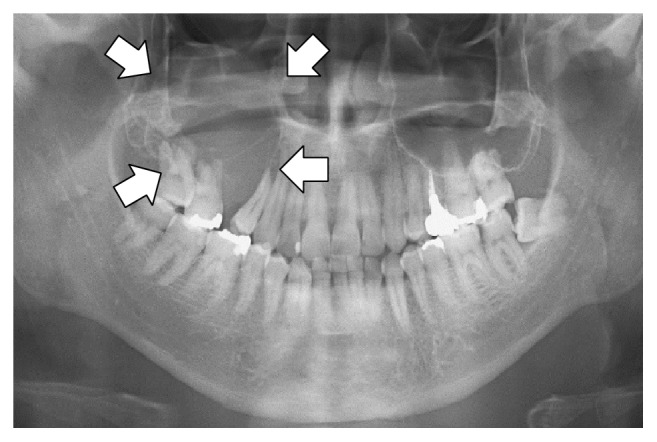

In [10]:
dataset[0]["image"]

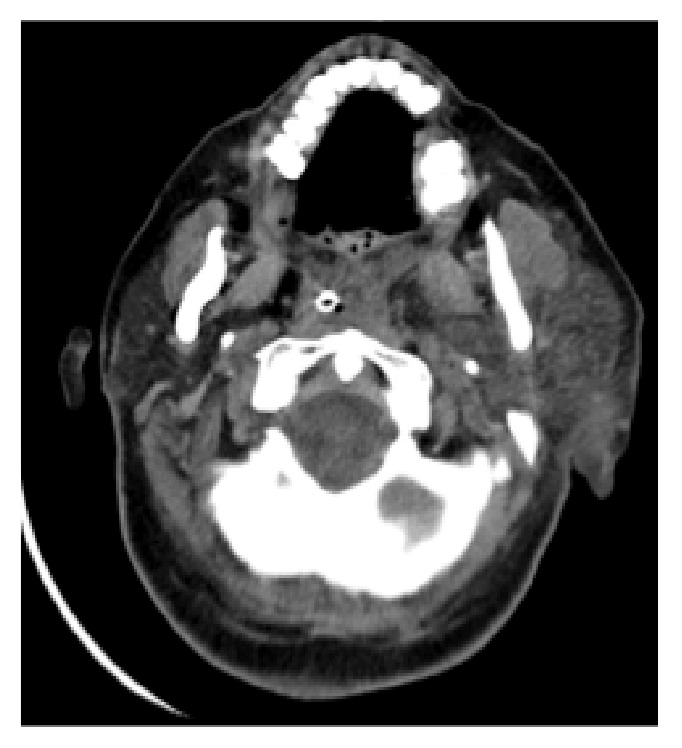

In [12]:
datasetFull[0]["image"]

In [13]:
dataset[0]["caption"]

'Panoramic radiography shows an osteolytic lesion in the right posterior maxilla with resorption of the floor of the maxillary sinus (arrows).'

In [14]:
datasetFull[0]["caption"]

'Head CT demonstrating left parotiditis.'

To format the dataset, all vision finetuning tasks should be formatted as follows:

```python
[
{ "role": "user",
  "content": [{"type": "text",  "text": instruction}, {"type": "image", "image": image} ]
},
{ "role": "assistant",
  "content": [{"type": "text",  "text": answer} ]
},
]
```

We will craft an custom instruction asking the VLM to be an expert radiographer. Notice also instead of just 1 instruction, you can add multiple turns to make it a dynamic conversation.

In [16]:
instruction = "You are an expert radiographer. Describe accurately what you see in this image."

def convert_to_conversation(sample):
    conversation = [
        { "role": "user",
          "content" : [
            {"type" : "text",  "text"  : instruction},
            {"type" : "image", "image" : sample["image"]} ]
        },
        { "role" : "assistant",
          "content" : [
            {"type" : "text",  "text"  : sample["caption"]} ]
        },
    ]
    return { "messages" : conversation }
pass

Let's convert the dataset into the "correct" format for finetuning:

In [17]:
converted_dataset = [convert_to_conversation(sample) for sample in dataset]

The first example is now structured like below:

In [2]:
converted_dataset[0]

NameError: name 'converted_dataset' is not defined

In [1]:
converted_Full_dataset = [convert_to_conversation(sample) for sample in datasetFull]

NameError: name 'datasetFull' is not defined

In [ ]:
converted_Full_dataset[0]

Before we do any finetuning, maybe the vision model already knows how to analyse the images? Let's check if this is the case!

In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]
instruction = "You are an expert radiographer. Describe accurately what you see in this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

This radiograph appears to be a panoramic view of the upper and lower dentition, specifically an Orthopantomogram (OPG).

* The panoramic radiograph demonstrates normal dental structures.
* There is an abnormal area on the upper right, represented by an area of radiolucent bone, corresponding to the antrum.

**Key Observations**

* The bone between the left upper teeth is relatively radiopaque.
* There are two large arrows above the image, suggesting the need for a closer examination of this area. One of the arrows is in a left-sided position, and the other is in the right-sided position. However, only


<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

We use our new `UnslothVisionDataCollator` which will help in our vision finetuning setup.

In [ ]:
from unsloth import is_bf16_supported
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig

FastVisionModel.for_training(model) # Enable for training!

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    data_collator = UnslothVisionDataCollator(model, tokenizer), # Must use!
    train_dataset = converted_dataset,
    args = SFTConfig(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 30,
        # num_train_epochs = 1, # Set this instead of max_steps for full training runs
        learning_rate = 2e-4,
        fp16 = not is_bf16_supported(),
        bf16 = is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none",     # For Weights and Biases

        # You MUST put the below items for vision finetuning:
        remove_unused_columns = False,
        dataset_text_field = "",
        dataset_kwargs = {"skip_prepare_dataset": True},
        dataset_num_proc = 4,
        max_seq_length = 2048,
    ),
)

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.748 GB.
8.477 GB of memory reserved.


In [ ]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 1,978 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 2 | Gradient Accumulation steps = 4
\        /    Total batch size = 8 | Total steps = 30
 "-____-"     Number of trainable parameters = 67,174,400
🦥 Unsloth needs about 1-3 minutes to load everything - please wait!


Step,Training Loss
1,3.611500
2,3.613000
3,3.488000
4,3.600900
5,3.031900
6,2.884400
7,2.446000
8,2.323400
9,1.984300
10,1.647600


In [ ]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

957.9653 seconds used for training.
15.97 minutes used for training.
Peak reserved memory = 10.287 GB.
Peak reserved memory for training = 1.81 GB.
Peak reserved memory % of max memory = 69.752 %.
Peak reserved memory for training % of max memory = 12.273 %.


<a name="Inference"></a>
### Inference
Let's run the model! You can change the instruction and input - leave the output blank!

We use `min_p = 0.1` and `temperature = 1.5`. Read this [Tweet](https://x.com/menhguin/status/1826132708508213629) for more information on why.

In [ ]:
FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]
instruction = "You are an expert radiographer. Describe accurately what you see in this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

Panoramic radiography shows multiple small osteolytic lesions in the right mandibular ramus, condyle and ascending ramus, the left mandibular condyle, left first molar and body, right first and second premolar, left first, second and third molars (arrows).<|eot_id|>


<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [ ]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

[]

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [ ]:
if False:
    from unsloth import FastVisionModel
    model, tokenizer = FastVisionModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        load_in_4bit = True, # Set to False for 16bit LoRA
    )
    FastVisionModel.for_inference(model) # Enable for inference!

image = dataset[0]["image"]
instruction = "You are an expert radiographer. Describe accurately what you see in this image."

messages = [
    {"role": "user", "content": [
        {"type": "image"},
        {"type": "text", "text": instruction}
    ]}
]
input_text = tokenizer.apply_chat_template(messages, add_generation_prompt = True)
inputs = tokenizer(
    image,
    input_text,
    add_special_tokens = False,
    return_tensors = "pt",
).to("cuda")

from transformers import TextStreamer
text_streamer = TextStreamer(tokenizer, skip_prompt = True)
_ = model.generate(**inputs, streamer = text_streamer, max_new_tokens = 128,
                   use_cache = True, temperature = 1.5, min_p = 0.1)

Panoramic radiograph of the jaw showing well-defined radiolucency (arrowheads) of the right side and unerupted second permanent maxillary molar (arrow).<|eot_id|>


### Saving to float16 for VLLM

We also support saving to `float16` directly. Select `merged_16bit` for float16. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [ ]:
# Select ONLY 1 to save! (Both not needed!)

# Save locally to 16bit
if False: model.save_pretrained_merged("unsloth_finetune", tokenizer,)

# To export and save to your Hugging Face account
if False: model.push_to_hub_merged("YOUR_USERNAME/unsloth_finetune", tokenizer, token = "PUT_HERE")

And we're done! If you have any questions on Unsloth, we have a [Discord](https://discord.gg/u54VK8m8tk) channel! If you find any bugs or want to keep updated with the latest LLM stuff, or need help, join projects etc, feel free to join our Discord!

If you want to finetune Llama-3 2x faster and use 70% less VRAM, go to our [finetuning notebook](https://colab.research.google.com/drive/135ced7oHytdxu3N2DNe1Z0kqjyYIkDXp?usp=sharing)!

Some other links:
1. Zephyr DPO 2x faster [free Colab](https://colab.research.google.com/drive/15vttTpzzVXv_tJwEk-hIcQ0S9FcEWvwP?usp=sharing)
2. Llama 7b 2x faster [free Colab](https://colab.research.google.com/drive/1lBzz5KeZJKXjvivbYvmGarix9Ao6Wxe5?usp=sharing)
3. TinyLlama 4x faster full Alpaca 52K in 1 hour [free Colab](https://colab.research.google.com/drive/1AZghoNBQaMDgWJpi4RbffGM1h6raLUj9?usp=sharing)
4. CodeLlama 34b 2x faster [A100 on Colab](https://colab.research.google.com/drive/1y7A0AxE3y8gdj4AVkl2aZX47Xu3P1wJT?usp=sharing)
5. Mistral 7b [free Kaggle version](https://www.kaggle.com/code/danielhanchen/kaggle-mistral-7b-unsloth-notebook)
6. We also did a [blog](https://huggingface.co/blog/unsloth-trl) with 🤗 HuggingFace, and we're in the TRL [docs](https://huggingface.co/docs/trl/main/en/sft_trainer#accelerate-fine-tuning-2x-using-unsloth)!
7. Text completions like novel writing [notebook](https://colab.research.google.com/drive/1ef-tab5bhkvWmBOObepl1WgJvfvSzn5Q?usp=sharing)
9. Gemma 6 trillion tokens is 2.5x faster! [free Colab](https://colab.research.google.com/drive/10NbwlsRChbma1v55m8LAPYG15uQv6HLo?usp=sharing)

<div class="align-center">
  <a href="https://unsloth.ai"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
  <a href="https://discord.gg/u54VK8m8tk"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord.png" width="145"></a>
  <a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a>

 Join Discord if you need help + ⭐ <i>Star us on <a href="https://github.com/unslothai/unsloth">Github</a> </i> ⭐
</div>
